In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import History 
from keras.models import Sequential
from tensorflow.keras import layers

from random import randint
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Making the dataset:

In [ ]:
# Create 250 squares
NUM_SQUARES = 250
WIDTH = 128

X_train = []
for i in range(NUM_SQUARES):
    exp = np.zeros((WIDTH, WIDTH)) #  128*128 canvas 
    x_start = randint(0, WIDTH - 1)
    x_end = randint(x_start, WIDTH)
    y_start = randint(0, WIDTH - 1)
    y_end = randint(y_start, WIDTH)
    for x in range(y_start, y_end):
        for y in range(y_start, y_end):
            exp[x, y] = 1
    X_train.append(exp)

In [ ]:
# Create 250 circles
for i in range(NUM_SQUARES):
    x = np.arange(0, WIDTH)
    y = np.arange(0, WIDTH)
    arr = np.zeros((y.size, x.size))

    cx = randint(0, WIDTH)
    cy = randint(0, WIDTH)
    r = randint(0, WIDTH / 2)

    # The two lines below could be merged, but I stored the mask
    # for code clarity.
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < r**2
    arr[mask] = 1
    if randint(0, 1) == 0: # sometie true
        arr = np.fliplr(arr)
    X_train.append(arr)
print(len(X_train))

500


In [ ]:
Y_train = np.array([1 if i < NUM_SQUARES else 0 for i in range(NUM_SQUARES * 2)])

In [ ]:
# Shuffle training data
shuffler = np.random.permutation(NUM_SQUARES*2)

X_train = np.array(X_train)

shufled_X_train = X_train[shuffler]
shufled_Y_train = Y_train[shuffler]

0


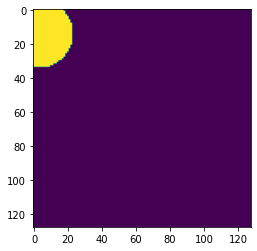

In [ ]:
print(shufled_Y_train[100])
plt.imshow(shufled_X_train[100])

## Splitting the data:

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,
                                                    stratify=Y_train, 
                                                    test_size=0.2)

print(x_train.shape)
print(x_test.shape)

(400, 128, 128)
(100, 128, 128)


In [ ]:
# Reshaping as per requirement

x_wanted_train = x_train.reshape(len(x_train), WIDTH, WIDTH, 1)
x_wanted_test = x_test.reshape(len(x_test), WIDTH, WIDTH, 1)

## Augmenting the data:

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [ ]:
datagen.fit(x_wanted_train)

# Model Work: 

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
# Adding some extra layers before the input to deal with a single channel image
# vgg takes a 3 channel input
img_input = layers.Input(shape=(WIDTH, WIDTH, 1))
img_conc = layers.Concatenate()([img_input, img_input, img_input])

# Load model without classifier/fully connected layers
# the top 3 layers are the fully connected dense layers when we say include_top = False
# it means we don't want them, we only want the Convolutional layers
VGG_model = VGG16(input_tensor=img_conc, weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False

In [ ]:
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 3)  0           ['input_1[0][0]',                
                                                                  'input_1[0][0]',                
                                                                  'input_1[0][0]']                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['concatenate[0][0]']        

## Creating the model:

In [ ]:
INPUT_SHAPE = (WIDTH, WIDTH)   

model = Sequential()
# to add the extra dimesion in the image
#model.add(layers.Reshape((WIDTH, WIDTH, 1), input_shape=INPUT_SHAPE))
# using the vgg-16 CNN with learned features, no learning now
model.add(VGG_model)
# flattening the multiple dimension output from the CNN
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop', 
              metrics=['accuracy'])

## Training the model

In [ ]:
history = model.fit(datagen.flow(x_wanted_train, y_train, batch_size=32,
         subset='training'),
         validation_data=datagen.flow(x_wanted_test, y_test,
         batch_size=8, subset='validation'),
#          steps_per_epoch=len(x_train) // 32, 
#         validation_steps = len(x_train) // 8,
        epochs=5)

Epoch 1/5
10/10 [==============================] - 65s 6s/step - loss: 1.1757 - accuracy: 0.7563 - val_loss: 0.9251 - val_accuracy: 0.7000
Epoch 2/5
10/10 [==============================] - 58s 6s/step - loss: 0.1738 - accuracy: 0.9406 - val_loss: 0.1876 - val_accuracy: 0.9000
Epoch 3/5
10/10 [==============================] - 56s 6s/step - loss: 0.1588 - accuracy: 0.9344 - val_loss: 0.4483 - val_accuracy: 0.8500
Epoch 4/5
10/10 [==============================] - 56s 6s/step - loss: 0.2264 - accuracy: 0.9250 - val_loss: 0.2007 - val_accuracy: 0.9000
Epoch 5/5
10/10 [==============================] - 56s 6s/step - loss: 0.2044 - accuracy: 0.9125 - val_loss: 0.1297 - val_accuracy: 0.9500


## Visualizing Results:

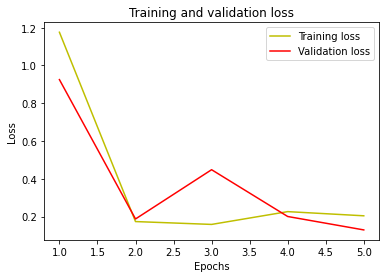

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

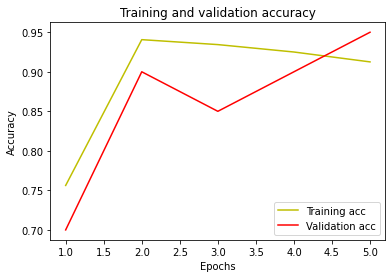

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Taking a prediction:

The prediction for this image is:  1
The actual label for this image is:  1


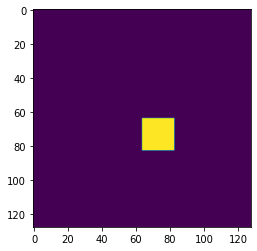

In [ ]:
n = 71  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)

input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y)

print("The prediction for this image is: ", round(model.predict(input_img)[0][0]))
print("The actual label for this image is: ", y_test[n])